# Modeling

## 1. Load + Define Snapshot Rules

In [1]:
# Section 1: Load gold_master + integrity checks 
import os, sys
import numpy as np
import pandas as pd
from pathlib import Path

# Locate gold_master.parquet (robust to cwd) 
_nb_dir = Path.cwd()
_candidates = [
    Path.cwd() / "data" / "gold" / "gold_master.parquet",
    Path.cwd() / ".." / "EDA" / "data" / "gold" / "gold_master.parquet",
    Path.cwd().parent / "EDA" / "data" / "gold" / "gold_master.parquet",
    Path.cwd().parent / "data" / "gold" / "gold_master.parquet",
]
GOLD_PATH = next((p for p in _candidates if p.exists()), None)

if GOLD_PATH is None:
    _tried = "\n  ".join(str(p.resolve()) for p in _candidates)
    raise FileNotFoundError(f"gold_master.parquet not found. Tried:\n  {_tried}")

print(f"GOLD_PATH -> {GOLD_PATH.resolve()}")

gold = pd.read_parquet(GOLD_PATH)
print("Loaded gold_master:", gold.shape)

GOLD_PATH -> /Users/crissafrancisco/Desktop/IE/Third Term/Capstone/data/gold/gold_master.parquet
Loaded gold_master: (20099, 70)


In [2]:
# Key integrity checks 
required = ["customer_id", "churn"]
missing_req = [c for c in required if c not in gold.columns]
assert not missing_req, f"Missing required columns: {missing_req}"

n_rows   = len(gold)
n_unique = gold["customer_id"].nunique()
n_dups   = gold["customer_id"].duplicated().sum()
print(f"Rows            : {n_rows:,}")
print(f"Unique customers: {n_unique:,}")
print(f"Duplicate rows  : {n_dups:,}")
assert n_dups == 0, "Duplicate customer_id rows detected."

print("\nChurn distribution:")
print(gold["churn"].value_counts(dropna=False))
print("\nChurn rate:", gold["churn"].mean().round(4))

bad_labels = gold.loc[~gold["churn"].isin([0, 1]) | gold["churn"].isna()]
print(f"Bad/missing labels: {len(bad_labels)}")
assert len(bad_labels) == 0, "Non-binary or missing churn labels found." 

Rows            : 20,099
Unique customers: 20,099
Duplicate rows  : 0

Churn distribution:
churn
0    18097
1     2002
Name: count, dtype: int64

Churn rate: 0.0996
Bad/missing labels: 0


In [3]:
# Column overview 
print("Numeric columns:")
print(gold.select_dtypes(include=["number"]).columns.tolist())

print("\nCategorical / string columns:")
print(gold.select_dtypes(include=["object", "string", "category"]).columns.tolist())

Numeric columns:
['churn', 'is_second_residence', 'contracted_power_kw', 'is_urban', 'months_to_renewal', 'tenure_months', 'has_interaction', 'is_expired_contract', 'is_comparison_channel', 'is_own_website_channel', 'avg_monthly_elec_kwh', 'total_elec_kwh_2024', 'avg_monthly_gas_m3', 'total_gas_m3_2024', 'avg_monthly_margin', 'total_margin_2024', 'is_digital_channel', 'gas_share_of_revenue', 'province_avg_elec_cost_2024', 'province_avg_gas_cost_2024', 'price_update_count', 'std_monthly_elec_kwh', 'std_monthly_gas_m3', 'active_months_count', 'std_margin', 'min_monthly_margin', 'max_negative_margin', 'elec_price_trend_12m', 'gas_price_trend_12m', 'elec_price_volatility_12m', 'province_elec_cost_trend', 'elec_price_vs_province_cost_spread', 'is_price_increase', 'rolling_margin_trend', 'recent_complaint_flag', 'interaction_within_3m_of_renewal', 'is_interaction_within_30d_of_renewal', 'complaint_near_renewal', 'is_cancellation_intent', 'is_complaint_intent', 'intent_severity_score', 'month

In [4]:
# Missingness overview 
missing = gold.isna().mean().sort_values(ascending=False)
print("Top 20 most-missing columns:")
print(missing.head(20).to_string())

Top 20 most-missing columns:
gas_price_trend_12m                     0.819294
last_interaction_days_ago               0.680581
sentiment_label                         0.680581
is_negative_sentiment                   0.680581
months_since_last_change                0.303249
elec_price_trend_12m                    0.001841
elec_price_volatility_12m               0.000100
elec_price_vs_province_cost_spread      0.000100
has_interaction_x_renewal_bucket        0.000000
intent_severity_score                   0.000000
province_elec_cost_trend                0.000000
is_price_increase                       0.000000
rolling_margin_trend                    0.000000
customer_intent                         0.000000
recent_complaint_flag                   0.000000
interaction_within_3m_of_renewal        0.000000
is_interaction_within_30d_of_renewal    0.000000
complaint_near_renewal                  0.000000
is_cancellation_intent                  0.000000
is_complaint_intent                     

## 2. Define Feature Tiers (Modeling Experiment Ladder)

Feature tiers mirror the EDA signal hierarchy and are added **cumulatively** to isolate
incremental lift at each stage.

| Experiment | Tiers included | What we test |
|------------|---------------|--------------| 
| E0 | TIER_1A | Structural baseline: lifecycle timing + static attributes |
| E1 | + TIER_MP_CORE | Market & Portfolio Core: consumption, portfolio, pricing structure |
| E2 | + TIER_MP_RISK | Market & Portfolio Risk: price trends, volatility, margin stability |
| E3 | + TIER_2A | Behavioral presence: intent, complaints, interaction timing |
| E4 | + TIER_2B | Sentiment layer: NLP-derived emotional tone |
| E5 | + TIER_3 | Compound context flags: lifecycle × behavioral binary interactions |
| E6 | + TIER_1B | Full pre-computed interaction string set (linear models only) |
| E7 | All tiers | Full model |
| E8 | E7 without TIER_2B | Ablation: no sentiment (production fallback if NLP unavailable) |

**Margin columns:** `avg_monthly_margin` and `total_margin_2024` are **excluded from
all model training tiers** — EDA confirmed margin level is statistically irrelevant to
churn (median €6.96 churners vs €7.01 non-churners). They remain in gold for
post-prediction retention prioritisation: `expected_monthly_loss = P(churn) × avg_monthly_margin`.

**Gold notebook → Modeling tier mapping:**
- Gold Tier 1 (Lifecycle) + silver_customer structural → `TIER_1A`
- Gold TierMP_Core → `TIER_MP_CORE`
- Gold TierMP_Risk → `TIER_MP_RISK`
- Gold Tier 2 (Behavioral) → `TIER_2A`
- Gold Tier 3 Sentiment → `TIER_2B`
- Gold Tier 3 Compound flags → `TIER_3`
- Gold Tier 3 String interactions → `TIER_1B` (linear models only)

**Linear vs Tree rule**: Interaction string features (`_x_`) appear in `TIER_1B` for
linear models only. Tree models learn these splits natively via `TIER_3` compound flags.


In [6]:
# Feature tier definitions
TARGET = "churn"

# ══════════════════════════════════════════════════════════════════════════════
# Tier naming convention (experiment ladder):
#   TIER_1A  — Structural backbone: lifecycle timing + static customer attributes
#               (maps to Gold Tier 1 lifecycle + structural columns from silver_customer)
#   TIER_MP_CORE  — Market & Portfolio core: consumption, pricing structure
#   TIER_MP_RISK  — Market & Portfolio risk: price trends, volatility, margin stability
#   TIER_2A  — Behavioral presence: intent, complaints, interaction timing
#               (maps to Gold Tier 2 behavioral)
#   TIER_2B  — Sentiment signals: NLP-derived emotional tone
#               (maps to Gold Tier 3 sentiment)
#   TIER_3   — Compound context flags: pre-computed binary interaction flags
#               (maps to Gold Tier 3 compound signals)
#   TIER_1B  — Pre-computed interaction strings (linear models only; trees learn splits natively)
#               (maps to Gold Tier 3 string interactions)
#   TIER_LIFECYCLE_INTERACTIONS — EDA compound lifecycle signals (tree models only)
# ══════════════════════════════════════════════════════════════════════════════

# ── TIER 1A — Structural & Lifecycle ─────────────────────────────────────────
# Gold source: Tier 1 lifecycle (Behavioral_Base) + structural cols (silver_customer)
#              + Tier1A_Features (is_expired_contract, is_comparison_channel, etc.)
# EDA signal: renewal proximity is the #1 churn driver; tenure moderates it.
TIER_1A = [
    # Lifecycle timing (Gold Tier 1)
    "months_to_renewal",
    "renewal_bucket",
    "is_within_3m_of_renewal",
    "tenure_months",
    "tenure_bucket",
    "is_expired_contract",          # lapsed contracts have distinct churn profile
    # Static customer attributes (silver_customer)
    "segment",
    "sales_channel",
    "is_high_competition_province",
    "is_second_residence",
    "is_dual_fuel",
    "portfolio_type",
    "is_digital_channel",
    "is_comparison_channel",
    "is_own_website_channel",
]

# ── TIER MP_CORE — Market & Portfolio: Core Structure ────────────────────────
# Gold source: TierMP_Core
# EDA signal: moderate predictors; consumption + channel capture price-sensitivity proxy.
# NOTE: avg_monthly_margin and total_margin_2024 are EXCLUDED from model training.
# EDA: margin level is statistically irrelevant to churn (median €6.96 vs €7.01).
# These columns remain in gold_master for post-prediction retention prioritisation:
#   expected_monthly_loss = P(churn) × avg_monthly_margin
TIER_MP_CORE = [
    "avg_monthly_elec_kwh",
    "total_elec_kwh_2024",
    "avg_monthly_gas_m3",
    "total_gas_m3_2024",
    # avg_monthly_margin   ← EXCLUDED: noise per EDA; retained in gold for prioritisation
    # total_margin_2024    ← EXCLUDED: noise per EDA; retained in gold for prioritisation
    "gas_share_of_revenue",
    "price_update_count",
    "province_avg_elec_cost_2024",
    "province_avg_gas_cost_2024",
]

# ── TIER MP_RISK — Market & Portfolio: Stability & Risk ──────────────────────
# Gold source: TierMP_Risk
# EDA signal: margin stability and price evolution are secondary; noisier than lifecycle.
TIER_MP_RISK = [
    "std_monthly_elec_kwh",
    "std_monthly_gas_m3",
    "active_months_count",
    "std_margin",
    "min_monthly_margin",
    "max_negative_margin",
    "elec_price_trend_12m",
    "gas_price_trend_12m",
    "elec_price_volatility_12m",
    "province_elec_cost_trend",
    "elec_price_vs_province_cost_spread",
    "rolling_margin_trend",   # EDA s1: 3-month vs prior 3-month margin delta
    "is_price_increase",      # 1 if customer's electricity price went up in 2024
]

# ── TIER 2A — Behavioral Presence & Intent ───────────────────────────────────
# Gold source: Behavioral_Base (Gold Tier 2)
# EDA signal: interaction near renewal amplifies churn. Cancellation intent → ~99% churn.
TIER_2A = [
    "has_interaction",
    "interaction_within_3m_of_renewal",
    "is_interaction_within_30d_of_renewal",  # tighter urgency window
    "complaint_near_renewal",                # amplifier: complaint AND near renewal
    "recent_complaint_flag",
    "customer_intent",
    "last_interaction_days_ago",
    "is_cancellation_intent",
    "is_complaint_intent",
    "intent_severity_score",
    "months_since_last_change",
]

# ── TIER 2B — Sentiment Signals ───────────────────────────────────────────────
# Gold source: Behavioral_Base (Gold Tier 3 — sentiment)
# EDA signal: negative sentiment → near-deterministic churn (~99%). Highest single predictor.
TIER_2B = [
    "sentiment_label",
    "is_negative_sentiment",
    "complaint_x_negative_sentiment",   # compound: complaint + negative sentiment
]

# ── TIER 3 — Compound Context Flags (binary, tree-safe) ───────────────────────
# Gold source: Behavioral_Base (Gold Tier 3 — compound signals)
# EDA signal: lifecycle × behavioral compounds isolate the highest-risk customer segments.
# Binary/numeric only — interaction strings are in TIER_1B (linear) and TIER_LIFECYCLE_INTERACTIONS.
TIER_3 = [
    "is_price_sensitive",
    "is_high_risk_lifecycle",           # short tenure + near/at renewal
    "is_competition_x_renewal",         # competition province + near renewal
    "dual_fuel_x_renewal",              # dual fuel customer near renewal
    "dual_fuel_x_competition",          # dual fuel in high-competition province
    "dual_fuel_x_intent",               # dual fuel with cancellation/complaint intent
]

# ── TIER_LIFECYCLE_INTERACTIONS — EDA compound signals (tree models only) ────
# Gold source: Behavioral_Base (Gold Tier 3 — compound interactions as string features)
# Kept separate so they can be controlled independently in the experiment ladder.
# Trees learn these as native splits; they add interpretability shortcuts.
TIER_LIFECYCLE_INTERACTIONS = TIER_3  # alias — same features, separate experiment slot

# ── TIER 1B — Pre-computed interaction strings (linear models only) ───────────
# Gold source: Behavioral_Base (Gold Tier 3 — string interactions)
# EDA signal: intent × renewal and sentiment × renewal are the strongest interaction signals.
# Linear models need explicit string combinations; trees learn these splits natively.
TIER_1B = [
    "intent_x_renewal_bucket",
    "intent_x_tenure_bucket",
    "intent_x_sentiment",
    "sentiment_x_renewal_bucket",
    "tenure_x_renewal_bucket",
    "sales_channel_x_renewal_bucket",    # EDA s8: channel stickiness at renewal
    "has_interaction_x_renewal_bucket",  # EDA s4: interaction amplifier at renewal
    "competition_x_intent",              # EDA s7: competition amplifies complaint intent
]

# ── TIER_MP_RISK_EXTENDED — rolling margin trend variant ──────────────────────
# Use this in place of TIER_MP_RISK if rolling_margin_trend is confirmed in gold_master.
TIER_MP_RISK_EXTENDED = TIER_MP_RISK  # rolling_margin_trend already included above

# ── Seasonal note (not yet implemented) ───────────────────────────────────────
# Spanish energy contracts cluster on calendar cycles. A renewal_month/renewal_quarter
# feature would capture Q1 post-heating-season vs Q3 switching patterns.
# Add to gold notebook if next_renewal_date is retained as a column in gold_master.
# TIER_1A_SEASONAL = TIER_1A + ["renewal_month", "renewal_quarter"]

# ── Verify all tier features exist in gold ────────────────────────────────────

def dedupe(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

_all_tiers = dedupe(
    TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A + TIER_2B + TIER_3 + TIER_1B
)
_missing = [f for f in _all_tiers if f not in gold.columns]
if _missing:
    print(f"WARNING — {len(_missing)} features not yet in gold_master (activate after re-run):")
    for f in _missing:
        print(f"  {f}")
else:
    print(f"All {len(set(_all_tiers))} tier features confirmed in gold_master ✓")

_biz = [c for c in ["avg_monthly_margin", "total_margin_2024"] if c in gold.columns]
print(f"Business columns retained for prioritisation: {_biz}")


All 64 tier features confirmed in gold_master ✓
Business columns retained for prioritisation: ['avg_monthly_margin', 'total_margin_2024']


In [7]:
# Cumulative model feature sets (used for Section 3 matrix build & Section 6 baselines)
def dedupe(lst):
    seen = set()
    return [x for x in lst if not (x in seen or seen.add(x))]

MODEL_0_FEATURES = dedupe(TIER_1A)
MODEL_1_FEATURES = dedupe(MODEL_0_FEATURES + TIER_MP_CORE)
MODEL_2_FEATURES = dedupe(MODEL_1_FEATURES + TIER_MP_RISK)
MODEL_3_FEATURES = dedupe(MODEL_2_FEATURES + TIER_2A)
MODEL_4_FEATURES = dedupe(MODEL_3_FEATURES + TIER_2B)
MODEL_5_FEATURES = dedupe(MODEL_4_FEATURES + TIER_3)
MODEL_6_FEATURES = dedupe(MODEL_5_FEATURES + TIER_1B)
MODEL_7_FEATURES = dedupe(MODEL_6_FEATURES)   # full — same as M6 (TIER_1B is the last tier)

for name, feats in [
    ("M0 (structural)", MODEL_0_FEATURES),
    ("M1 (+MP core)",   MODEL_1_FEATURES),
    ("M2 (+MP risk)",   MODEL_2_FEATURES),
    ("M3 (+behavioral)",MODEL_3_FEATURES),
    ("M4 (+sentiment)", MODEL_4_FEATURES),
    ("M5 (+compound)",  MODEL_5_FEATURES),
    ("M6 (+strings)",   MODEL_6_FEATURES),
    ("M7 (full)",       MODEL_7_FEATURES),
]:
    print(f"{name}: {len(feats)} features")


M0 (structural): 15 features
M1 (+MP core): 23 features
M2 (+MP risk): 36 features
M3 (+behavioral): 47 features
M4 (+sentiment): 50 features
M5 (+compound): 56 features
M6 (+strings): 64 features
M7 (full): 64 features


In [8]:
# Tree model feature list helper
# Tree models learn feature interactions natively via splits, so pre-computed
# interaction strings (_x_) add redundancy rather than signal.

def make_tree_feature_list(feature_list):
    drop_exact = {"tenure_months_x_months_to_renewal"}
    return [
        f for f in feature_list
        if f not in drop_exact and "_x_" not in f
    ]

TREE_MODEL_0 = make_tree_feature_list(MODEL_0_FEATURES)
TREE_MODEL_1 = make_tree_feature_list(MODEL_1_FEATURES)
TREE_MODEL_2 = make_tree_feature_list(MODEL_2_FEATURES)
TREE_MODEL_3 = make_tree_feature_list(MODEL_3_FEATURES)
TREE_MODEL_4 = make_tree_feature_list(MODEL_4_FEATURES)
TREE_MODEL_5 = make_tree_feature_list(MODEL_5_FEATURES)
TREE_MODEL_7 = make_tree_feature_list(MODEL_7_FEATURES)

print(f"M7 linear features : {len(MODEL_7_FEATURES)}")
print(f"M7 tree features   : {len(TREE_MODEL_7)}")
print(f"Dropped for trees  : {set(MODEL_7_FEATURES) - set(TREE_MODEL_7)}")

M7 linear features : 64
M7 tree features   : 51
Dropped for trees  : {'intent_x_renewal_bucket', 'tenure_x_renewal_bucket', 'dual_fuel_x_competition', 'sentiment_x_renewal_bucket', 'intent_x_sentiment', 'dual_fuel_x_intent', 'intent_x_tenure_bucket', 'competition_x_intent', 'sales_channel_x_renewal_bucket', 'has_interaction_x_renewal_bucket', 'is_competition_x_renewal', 'complaint_x_negative_sentiment', 'dual_fuel_x_renewal'}


## 3. Model-Ready Dataset

The gold master contains one row per customer. We split into `X` (features), `y` (label),
and `customer_id` (key — excluded from model, used for tracking).

**Structural imputation** (applied before the sklearn pipeline):

| Column | Null meaning | Fill value |
|--------|-------------|-----------|
| `last_interaction_days_ago` | No interaction ever | `9999` (large = long ago) |
| `sentiment_label` | No interaction | `"no_interaction"` |
| `customer_intent` | No interaction | `"no_interaction"` |
| `sentiment_x_renewal_bucket` | No interaction | `"no_interaction"` |
| `intent_x_renewal_bucket` | No interaction | `"no_interaction"` |
| `intent_x_tenure_bucket` | No interaction | `"no_interaction"` |
| `intent_x_sentiment` | No interaction | `"no_interaction"` |
| `tenure_x_renewal_bucket` | No interaction | `"no_interaction"` |
| `sales_channel_x_renewal_bucket` | No interaction | `"no_interaction"` |
| `has_interaction_x_renewal_bucket` | No interaction | `"no_interaction"` |
| `competition_x_intent` | No interaction | `"no_interaction"` |

All binary interaction flags (`is_high_risk_lifecycle`, `is_competition_x_renewal`, etc.)
use `0` for customers with no interaction — absence of interaction is a signal in itself.

All other numeric nulls are handled by median imputation in the sklearn pipeline.

> **Note on validation methodology:** A time-based train/test split would better simulate
> production deployment (train on earlier cohorts, test on later ones). This is not implemented
> here because `gold_master` is a customer-level snapshot with no observation date column —
> all temporal information was aggregated out during the gold build. The stratified random
> split is statistically valid but assumes the churn process is stationary over time.
> For future iterations, retain a `cohort_month` column in gold_master.


In [9]:
# Missingness checker
def check_missingness(X):
    m = X.isna().mean().sort_values(ascending=False)
    return m[m > 0].rename("pct_missing").to_frame()

In [10]:
# Model matrix builder
# Structural imputation fills are applied BEFORE the sklearn pipeline.
# This converts "no interaction" nulls to meaningful sentinel values
# rather than letting median/mode imputation misrepresent them.

_STRUCTURAL_FILL_NUM = {
    "last_interaction_days_ago": 9999,
}
_STRUCTURAL_FILL_CAT = [
    # Sentiment + intent: NaN means no interaction recorded
    "sentiment_label",
    "customer_intent",
    # Pre-computed interaction strings: NaN means no interaction recorded
    "sentiment_x_renewal_bucket",
    "intent_x_renewal_bucket",
    "intent_x_tenure_bucket",
    "intent_x_sentiment",
    "tenure_x_renewal_bucket",
    "sales_channel_x_renewal_bucket",
    "has_interaction_x_renewal_bucket",
    "competition_x_intent",
]

def normalize_dtypes(X):
    """
    Normalise column dtypes so sklearn's imputer/OHE handle them cleanly:
      - bool  → int8   (SimpleImputer does not accept bool)
      - Categorical → str  (constant-fill imputer can't set 'missing' on ordered Categoricals)
      - pandas StringDtype → object  (OHE works best with plain object strings)
    """
    X = X.copy()
    for col in X.columns:
        dtype_str = str(X[col].dtype)
        if dtype_str == 'bool':
            X[col] = X[col].astype("int8")
        elif hasattr(X[col], 'cat'):          # Categorical
            X[col] = X[col].astype(str)
        elif dtype_str in ('string', 'StringDtype'):
            X[col] = X[col].astype(object)
    return X

def build_model_matrix(gold_df, feature_list):
    # Filter to features that actually exist in gold
    available = [f for f in feature_list if f in gold_df.columns]
    missing   = [f for f in feature_list if f not in gold_df.columns]
    if missing:
        print(f"WARNING: {len(missing)} features not in gold, skipped: {missing}")

    y           = gold_df["churn"].astype(int)
    customer_id = gold_df["customer_id"]
    X           = gold_df[available].copy()

    # Structural numeric fills
    for col, val in _STRUCTURAL_FILL_NUM.items():
        if col in X.columns:
            X[col] = X[col].fillna(val)

    # Structural categorical fills
    for col in _STRUCTURAL_FILL_CAT:
        if col in X.columns:
            X[col] = X[col].fillna("no_interaction").astype(str)

    # Normalise dtypes for sklearn compatibility
    X = normalize_dtypes(X)

    return X, y, customer_id

In [11]:
# Example: build model matrix for M5 (full feature set)
X, y, customer_id = build_model_matrix(gold, MODEL_5_FEATURES)

def sanity_check_matrix(X, y, customer_id):
    assert len(X) == len(y) == len(customer_id), "Row count mismatch!"
    print(f"X shape      : {X.shape}")
    print(f"Churn rate   : {y.mean():.4f}")
    non_num = X.select_dtypes(exclude=["number"]).columns.tolist()
    if non_num:
        print(f"Non-numeric  : {non_num}")
    else:
        print("Non-numeric  : none (all encoded or will be OHE in pipeline)")

sanity_check_matrix(X, y, customer_id)

print()
print("Top missing features in M5 matrix:")
print(check_missingness(X).head(10).to_string())

X shape      : (20099, 56)
Churn rate   : 0.0996
Non-numeric  : ['renewal_bucket', 'tenure_bucket', 'segment', 'sales_channel', 'portfolio_type', 'customer_intent', 'sentiment_label']

Top missing features in M5 matrix:
                                    pct_missing
gas_price_trend_12m                    0.819294
is_negative_sentiment                  0.680581
months_since_last_change               0.303249
elec_price_trend_12m                   0.001841
elec_price_volatility_12m              0.000100
elec_price_vs_province_cost_spread     0.000100


## 4. Preprocessing Pipeline

One unified `build_preprocessing_pipeline()` covers both linear and tree models.

**Numeric features**: median imputation → optional StandardScaler (on for LR, off for trees)
**Categorical features**: constant "missing" imputation → OneHotEncoder (handle_unknown=ignore)

The pipeline is wrapped inside sklearn `Pipeline` objects so preprocessing is fitted
on train data only — no leakage from the test set.

In [12]:
from sklearn.compose    import ColumnTransformer
from sklearn.pipeline   import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute     import SimpleImputer

In [13]:
def get_feature_types(X):
    """Split feature columns into numeric and categorical lists."""
    numeric_cols     = X.select_dtypes(include=["number"]).columns.tolist()
    categorical_cols = X.select_dtypes(exclude=["number"]).columns.tolist()
    return numeric_cols, categorical_cols

In [14]:
def build_preprocessing_pipeline(X, scale_numeric=True, ohe_sparse=False):
    """
    Returns a fitted-ready ColumnTransformer.

    Parameters
    ----------
    X             : feature DataFrame (used only for column type detection)
    scale_numeric : True for Logistic Regression; False for tree models
    ohe_sparse    : True to return sparse OHE matrix (memory-efficient for trees)
    """
    numeric_cols, categorical_cols = get_feature_types(X)

    numeric_steps = [("imputer", SimpleImputer(strategy="median"))]
    if scale_numeric:
        numeric_steps.append(("scaler", StandardScaler()))

    numeric_pipeline = Pipeline(numeric_steps)

    categorical_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("ohe",     OneHotEncoder(handle_unknown="ignore", sparse_output=ohe_sparse)),
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_pipeline,     numeric_cols),
            ("cat", categorical_pipeline, categorical_cols),
        ],
        remainder="drop",
    )
    return preprocessor

In [15]:
# Example: build preprocessors for M5
X, y, customer_id = build_model_matrix(gold, MODEL_5_FEATURES)
numeric_cols, categorical_cols = get_feature_types(X)

preprocessor_lr   = build_preprocessing_pipeline(X, scale_numeric=True,  ohe_sparse=False)
preprocessor_tree = build_preprocessing_pipeline(X, scale_numeric=False, ohe_sparse=True)

print(f"Numeric features ({len(numeric_cols)}):")
print(numeric_cols)
print(f"\nCategorical features ({len(categorical_cols)}):")
print(categorical_cols)

Numeric features (49):
['months_to_renewal', 'is_within_3m_of_renewal', 'tenure_months', 'is_expired_contract', 'is_high_competition_province', 'is_second_residence', 'is_dual_fuel', 'is_digital_channel', 'is_comparison_channel', 'is_own_website_channel', 'avg_monthly_elec_kwh', 'total_elec_kwh_2024', 'avg_monthly_gas_m3', 'total_gas_m3_2024', 'gas_share_of_revenue', 'price_update_count', 'province_avg_elec_cost_2024', 'province_avg_gas_cost_2024', 'std_monthly_elec_kwh', 'std_monthly_gas_m3', 'active_months_count', 'std_margin', 'min_monthly_margin', 'max_negative_margin', 'elec_price_trend_12m', 'gas_price_trend_12m', 'elec_price_volatility_12m', 'province_elec_cost_trend', 'elec_price_vs_province_cost_spread', 'rolling_margin_trend', 'is_price_increase', 'has_interaction', 'interaction_within_3m_of_renewal', 'is_interaction_within_30d_of_renewal', 'complaint_near_renewal', 'recent_complaint_flag', 'last_interaction_days_ago', 'is_cancellation_intent', 'is_complaint_intent', 'intent_

## 5. Train/Test Split Strategy

- The dataset is customer-level (one row per customer), so a standard split is appropriate.
- A **stratified train/test split** is used to preserve the churn distribution across train and test sets.

- 80/20 split: 80% training data, 20% holdout test data
- Stratification ensures:
  - Stable churn rate in both sets
  - Reliable performance evaluation under class imbalance

- **Optional:** `StratifiedKFold` cross-validation (5 folds) can be used for model selection and hyperparameter tuning while maintaining class balance.


In [16]:
from sklearn.model_selection import train_test_split, StratifiedKFold

# Train/test split (customer-level, stratified on churn)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train churn rate:", y_train.mean().round(4), "| n:", len(y_train))
print("Test  churn rate:", y_test.mean().round(4), "| n:", len(y_test))


# Optional: Stratified CV (use for model selection / tuning)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


Train churn rate: 0.0996 | n: 16079
Test  churn rate: 0.0995 | n: 4020


## 6. Define Baselines
- Baseline models establish a performance floor before introducing feature tiers or more complex algorithms.
- Comparing against Dummy classifiers ensures the modeling pipeline is leakage-free and that any lift is meaningful.
- Logistic Regression serves as a transparent, interpretable benchmark for incremental feature evaluation.

Results
- Logistic Regression baseline achieves strong performance (ROC-AUC ≈ 0.88, PR-AUC ≈ 0.63), substantially outperforming random guessing.
- Dummy classifiers perform at chance level (PR-AUC ≈ churn rate), validating the modeling setup and confirming genuine predictive signal.


In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    confusion_matrix,
)

from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt


In [18]:
# Baseline eval helpers
def pick_threshold_on_train(y_true, y_proba, mode="f1", target_recall=0.70):
    """
    Choose a decision threshold using TRAIN predictions only.
    mode:
      - "f1": maximize F1
      - "recall": smallest threshold achieving target_recall (good for churn capture)
    """
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # precision_recall_curve returns thresholds of length n-1; align by dropping last p/r
    precision, recall = precision[:-1], recall[:-1]

    if mode == "recall":
        idx = np.where(recall >= target_recall)[0]
        if len(idx) == 0:
            # fallback: best F1 if recall target not achievable
            f1 = 2 * (precision * recall) / (precision + recall + 1e-12)
            best = int(np.nanargmax(f1))
            return thresholds[best]
        return thresholds[int(idx[-1])]  # lowest threshold meeting recall target (more aggressive)
    else:  # mode == "f1"
        f1 = 2 * (precision * recall) / (precision + recall + 1e-12)
        best = int(np.nanargmax(f1))
        return thresholds[best]

In [19]:
def evaluate_classifier(name, model, X_train, y_train, X_test, y_test,
                        threshold_mode="recall", target_recall=0.70,
                        make_calibration_plot=False):
    """
    Fit on train, choose threshold on train, evaluate on test.
    Returns metrics dict + optional calibration plot.
    """
    model.fit(X_train, y_train)

    # probabilities
    p_train = model.predict_proba(X_train)[:, 1]
    p_test = model.predict_proba(X_test)[:, 1]

    # threshold chosen on TRAIN only
    thr = pick_threshold_on_train(y_train, p_train, mode=threshold_mode, target_recall=target_recall)

    # test predictions at chosen threshold
    yhat_test = (p_test >= thr).astype(int)

    out = {
        "model": name,
        "roc_auc": roc_auc_score(y_test, p_test),
        "pr_auc": average_precision_score(y_test, p_test),
        "threshold": float(thr),
        "precision@thr": precision_score(y_test, yhat_test, zero_division=0),
        "recall@thr": recall_score(y_test, yhat_test, zero_division=0),
        "tn_fp_fn_tp": confusion_matrix(y_test, yhat_test).ravel().tolist(),
    }

    if make_calibration_plot:
        fig, ax = plt.subplots()
        CalibrationDisplay.from_predictions(y_test, p_test, n_bins=10, ax=ax)
        ax.set_title(f"Calibration Plot — {name}")
        plt.show()

    return out

In [20]:
# Baseline models
# 1) Dummy baselines (no preprocessing needed)
dummy_most_freq = DummyClassifier(strategy="most_frequent", random_state=42)
dummy_strat = DummyClassifier(strategy="stratified", random_state=42)

# 2) Logistic Regression baseline (with preprocessing pipeline you already defined)
# Assumes you already created:
# preprocessor = build_preprocessing_pipeline(X_train, scale_numeric=True)
logit = Pipeline(steps=[
    ("preprocessor", preprocessor_lr),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",   # helpful with ~10% churn
        n_jobs=None,
        random_state=42
    ))
])

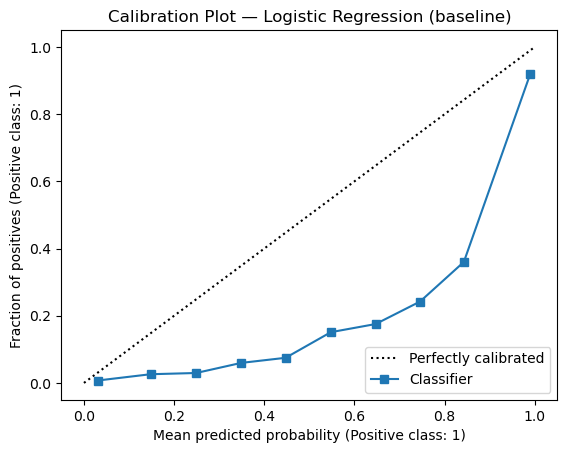

,model,roc_auc,pr_auc,threshold,precision@thr,recall@thr,tn_fp_fn_tp
2,Logistic Regression (baseline),0.889535,0.653823,0.635063,0.440932,0.6625,"[3284, 336, 135, 265]"
0,Dummy (most_frequent),0.500000,0.099502,0.000000,0.099502,1.0000,"[0, 3620, 0, 400]"
1,Dummy (stratified),0.498460,0.099235,0.000000,0.099502,1.0000,"[0, 3620, 0, 400]"


In [21]:
# Run baselines
results = []
results.append(evaluate_classifier(
    "Dummy (most_frequent)", dummy_most_freq,
    X_train, y_train, X_test, y_test,
    threshold_mode="f1",  # threshold isn't meaningful here; keep simple
    make_calibration_plot=False
))
results.append(evaluate_classifier(
    "Dummy (stratified)", dummy_strat,
    X_train, y_train, X_test, y_test,
    threshold_mode="f1",
    make_calibration_plot=False
))
results.append(evaluate_classifier(
    "Logistic Regression (baseline)", logit,
    X_train, y_train, X_test, y_test,
    threshold_mode="recall",   # choose threshold to hit recall target on TRAIN
    target_recall=0.70,
    make_calibration_plot=True  # optional
))

baseline_results = pd.DataFrame(results).sort_values(["roc_auc", "pr_auc"], ascending=False)
baseline_results


## 7. Model Experiment Ladder

Feature tiers are added incrementally to isolate the marginal impact of each signal group.
Each experiment is evaluated using PR-AUC (primary, imbalance-aware), ROC-AUC, precision, and recall.
The ladder runs for linear (logistic regression), random forest, and XGBoost models.

**Note on missing new features:** New EDA-derived features (`is_expired_contract`,
`is_negative_sentiment`, compound lifecycle interactions, etc.) are not yet in the
current `gold_master.parquet`. They are defined in the tier config above as commented-out
lines and will activate automatically once the gold notebook is re-run.

In [22]:
# Experiment ladder — cumulative tier addition to isolate incremental lift
# Each experiment adds one tier to the previous; champion is selected by PR-AUC.

def dedupe(seq):
    seen = set()
    out = []
    for x in seq:
        if x not in seen:
            out.append(x)
            seen.add(x)
    return out

EXPERIMENTS_LINEAR = {
    # E0: Structural baseline — lifecycle timing + static customer attributes
    "E0_Tier1A":               dedupe(TIER_1A),

    # E1: + Market & Portfolio Core (consumption, pricing — margin excluded per EDA)
    "E1_plus_MP_core":         dedupe(TIER_1A + TIER_MP_CORE),

    # E2: + Market & Portfolio Risk (price trends, volatility, margin stability)
    "E2_plus_MP_risk":         dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK),

    # E3: + Behavioral presence (intent, complaints, interaction timing)
    "E3_plus_behavioral":      dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A),

    # E4: + Sentiment (EDA: negative sentiment → ~99% churn — expected large lift)
    "E4_plus_sentiment":       dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A + TIER_2B),

    # E5: + Compound context flags (binary lifecycle × behavioral interactions)
    "E5_plus_compound":        dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A + TIER_2B + TIER_3),

    # E6: + Pre-computed interaction strings (linear models pick these up natively)
    "E6_plus_strings":         dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A + TIER_2B + TIER_3 + TIER_1B),

    # E7: Full model — all tiers
    "E7_full":                 dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A + TIER_2B + TIER_3 + TIER_1B),

    # E8: Ablation — no sentiment (production fallback if CRM NLP scoring is unavailable)
    # EDA: negative sentiment → ~99% churn; quantify PR-AUC cost of losing this signal.
    "E8_ablation_no_sentiment": dedupe(TIER_1A + TIER_MP_CORE + TIER_MP_RISK + TIER_2A + TIER_3 + TIER_1B),
}

EXPERIMENTS_LINEAR = {k: dedupe(v) for k, v in EXPERIMENTS_LINEAR.items()}

print("Experiment feature counts:")
for name, feats in EXPERIMENTS_LINEAR.items():
    print(f"  {name}: {len(feats)} features")

# E8 ablation check: confirm no sentiment features leaked in
_e8 = EXPERIMENTS_LINEAR["E8_ablation_no_sentiment"]
_sent_in_e8 = [f for f in _e8 if any(s in f for s in ["sentiment", "is_negative"])]
print(f"\nE8 ablation — sentiment features present: {_sent_in_e8 if _sent_in_e8 else 'None ✓'}")


Experiment feature counts:
  E0_Tier1A: 15 features
  E1_plus_MP_core: 23 features
  E2_plus_MP_risk: 36 features
  E3_plus_behavioral: 47 features
  E4_plus_sentiment: 50 features
  E5_plus_compound: 56 features
  E6_plus_strings: 64 features
  E7_full: 64 features
  E8_ablation_no_sentiment: 61 features

E8 ablation — sentiment features present: ['intent_x_sentiment', 'sentiment_x_renewal_bucket']


In [23]:
# Tree-safe experiment sets: drop _x_ STRING interactions (trees learn splits natively)
# NOTE: Binary compound flags like is_competition_x_renewal, dual_fuel_x_renewal etc.
# use _x_ in their name but are numeric/binary features — they should NOT be dropped.
# Rule: drop only features in TIER_1B (explicit string interaction tier).
_TIER_1B_SET = set(TIER_1B)

def make_tree_feature_list(feature_list):
    # Drop features that are string pre-computed interactions (in TIER_1B)
    # but keep binary compound flags even if they have _x_ in the name
    return [f for f in feature_list if f not in _TIER_1B_SET]

EXPERIMENTS_TREE = {
    k: make_tree_feature_list(v)
    for k, v in EXPERIMENTS_LINEAR.items()
}

print("Tree experiment feature counts:")
for name, feats in EXPERIMENTS_TREE.items():
    print(f"  {name}: {len(feats)} features")

# Verify: interaction strings dropped in tree version vs linear
_e5_lin  = len(EXPERIMENTS_LINEAR["E5_plus_compound"])
_e5_tree = len(EXPERIMENTS_TREE["E5_plus_compound"])
print(f"\nE5: linear={_e5_lin}, tree={_e5_tree} ({_e5_lin - _e5_tree} string cols dropped for trees)")


Tree experiment feature counts:
  E0_Tier1A: 15 features
  E1_plus_MP_core: 23 features
  E2_plus_MP_risk: 36 features
  E3_plus_behavioral: 47 features
  E4_plus_sentiment: 50 features
  E5_plus_compound: 56 features
  E6_plus_strings: 56 features
  E7_full: 56 features
  E8_ablation_no_sentiment: 53 features

E5: linear=56, tree=56 (0 string cols dropped for trees)


In [25]:
# Rebuild X/y using full superset (E7)
FULL_FEATURES = EXPERIMENTS_LINEAR["E7_full"]

X, y, customer_id = build_model_matrix(gold, FULL_FEATURES)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print(f"Full feature set   : {len(FULL_FEATURES)} features")
print(f"Train shape        : {X_train.shape}  |  churn rate: {y_train.mean():.4f}")
print(f"Test shape         : {X_test.shape}   |  churn rate: {y_test.mean():.4f}")

Full feature set   : 64 features
Train shape        : (16079, 64)  |  churn rate: 0.0996
Test shape         : (4020, 64)   |  churn rate: 0.0995


In [26]:
# Build preprocessing objects — X must be passed so pipeline detects column types
preprocessor_lr   = build_preprocessing_pipeline(X, scale_numeric=True,  ohe_sparse=False)
preprocessor_tree = build_preprocessing_pipeline(X, scale_numeric=False, ohe_sparse=True)

numeric_cols, categorical_cols = get_feature_types(X)
print(f"Numeric features    : {len(numeric_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

Numeric features    : 49
Categorical features: 15


In [27]:
# Define models (Linear Regression, Random Forest, XGBoost)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Logistic
lr_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    n_jobs=-1
)

# XGBoost
pos = y_train.sum()
neg = len(y_train) - pos
spw = float(neg / max(pos, 1))

xgb_model = XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=spw,
    random_state=42,
    n_jobs=-1
)


In [28]:
# Evaluation Utilities
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, precision_score, recall_score, confusion_matrix
import numpy as np
import pandas as pd


def pick_threshold(y_true, y_proba, target_recall=0.70):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    precision, recall = precision[:-1], recall[:-1]
    idx = np.where(recall >= target_recall)[0]
    if len(idx) == 0:
        return 0.5
    return thresholds[idx[-1]]


def evaluate(name, pipe, X_tr, y_tr, X_te, y_te):
    pipe.fit(X_tr, y_tr)
    p_tr = pipe.predict_proba(X_tr)[:, 1]
    p_te = pipe.predict_proba(X_te)[:, 1]

    thr = pick_threshold(y_tr, p_tr)
    yhat = (p_te >= thr).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_te, yhat).ravel()

    return {
        "experiment": name,
        "roc_auc": roc_auc_score(y_te, p_te),
        "pr_auc": average_precision_score(y_te, p_te),
        "precision": precision_score(y_te, yhat, zero_division=0),
        "recall": recall_score(y_te, yhat, zero_division=0),
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }


In [29]:
# Run logistic ladder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

results_lr = []

for name, feats in EXPERIMENTS_LINEAR.items():
    Xtr = X_train[feats].copy()
    Xte = X_test[feats].copy()

    # Rebuild preprocessor per experiment — each subset has a different column set
    pre = build_preprocessing_pipeline(Xtr, scale_numeric=True, ohe_sparse=False)

    lr = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42)

    pipe = Pipeline([
        ("preprocessor", pre),
        ("model", lr)
    ])

    row = evaluate(name, pipe, Xtr, y_train, Xte, y_test)
    row["algorithm"] = "logistic"
    results_lr.append(row)

results_lr = pd.DataFrame(results_lr)
results_lr

,experiment,roc_auc,pr_auc,precision,recall,tn,fp,fn,tp,algorithm
0,E0_Tier1A,0.778372,0.260065,0.228692,0.6775,2706,914,129,271,logistic
1,E1_plus_MP_core,0.783814,0.266805,0.233613,0.6950,2708,912,122,278,logistic
2,E2_plus_MP_risk,0.795265,0.295940,0.244952,0.6975,2760,860,121,279,logistic
3,E3_plus_behavioral,0.857900,0.584191,0.361149,0.6600,3153,467,136,264,logistic
4,E4_plus_sentiment,0.889398,0.654413,0.442596,0.6650,3285,335,134,266,logistic
5,E5_plus_compound,0.889535,0.653823,0.440932,0.6625,3284,336,135,265,logistic
6,E6_plus_strings,0.883134,0.652548,0.448393,0.6625,3294,326,135,265,logistic
7,E7_full,0.883134,0.652548,0.448393,0.6625,3294,326,135,265,logistic
8,E8_ablation_no_sentiment,0.883803,0.653168,0.447635,0.6625,3293,327,135,265,logistic


In [30]:
results_rf = []

for name, feats in EXPERIMENTS_TREE.items():
    Xtr = X_train[feats].copy()
    Xte = X_test[feats].copy()

    # Rebuild preprocessor per experiment
    pre = build_preprocessing_pipeline(Xtr, scale_numeric=False, ohe_sparse=True)

    rf = RandomForestClassifier(
        n_estimators=400, random_state=42,
        class_weight="balanced_subsample", n_jobs=-1
    )

    pipe = Pipeline([
        ("preprocessor", pre),
        ("model", rf)
    ])

    row = evaluate(name, pipe, Xtr, y_train, Xte, y_test)
    row["algorithm"] = "random_forest"
    results_rf.append(row)

results_rf = pd.DataFrame(results_rf)
results_rf

,experiment,roc_auc,pr_auc,precision,recall,tn,fp,fn,tp,algorithm
0,E0_Tier1A,0.767317,0.260298,0.411765,0.0525,3590,30,379,21,random_forest
1,E1_plus_MP_core,0.827515,0.378429,0.631579,0.0300,3613,7,388,12,random_forest
2,E2_plus_MP_risk,0.848092,0.449247,0.833333,0.0250,3618,2,390,10,random_forest
3,E3_plus_behavioral,0.892957,0.659371,0.991304,0.2850,3619,1,286,114,random_forest
4,E4_plus_sentiment,0.909027,0.716608,0.993007,0.3550,3619,1,258,142,random_forest
5,E5_plus_compound,0.911061,0.716132,0.993056,0.3575,3619,1,257,143,random_forest
6,E6_plus_strings,0.911061,0.716132,0.993056,0.3575,3619,1,257,143,random_forest
7,E7_full,0.911061,0.716132,0.993056,0.3575,3619,1,257,143,random_forest
8,E8_ablation_no_sentiment,0.893768,0.660114,0.991379,0.2875,3619,1,285,115,random_forest


In [31]:
results_xgb = []

pos = y_train.sum()
neg = len(y_train) - pos
spw = float(neg / max(pos, 1))

for name, feats in EXPERIMENTS_TREE.items():
    Xtr = X_train[feats].copy()
    Xte = X_test[feats].copy()

    # Rebuild preprocessor per experiment
    pre = build_preprocessing_pipeline(Xtr, scale_numeric=False, ohe_sparse=True)

    xgb = XGBClassifier(
        n_estimators=600, learning_rate=0.05, max_depth=5,
        subsample=0.8, colsample_bytree=0.8,
        objective="binary:logistic", eval_metric="logloss",
        scale_pos_weight=spw, random_state=42, n_jobs=-1
    )

    pipe = Pipeline([
        ("preprocessor", pre),
        ("model", xgb)
    ])

    row = evaluate(name, pipe, Xtr, y_train, Xte, y_test)
    row["algorithm"] = "xgboost"
    results_xgb.append(row)

results_xgb = pd.DataFrame(results_xgb)
results_xgb

,experiment,roc_auc,pr_auc,precision,recall,tn,fp,fn,tp,algorithm
0,E0_Tier1A,0.795195,0.305048,0.322526,0.4725,3223,397,211,189,xgboost
1,E1_plus_MP_core,0.846588,0.417568,0.486395,0.3575,3469,151,257,143,xgboost
2,E2_plus_MP_risk,0.869015,0.475804,0.644330,0.3125,3551,69,275,125,xgboost
3,E3_plus_behavioral,0.913039,0.685069,0.856410,0.4175,3592,28,233,167,xgboost
4,E4_plus_sentiment,0.933006,0.744774,0.905213,0.4775,3600,20,209,191,xgboost
5,E5_plus_compound,0.931157,0.744913,0.894231,0.4650,3598,22,214,186,xgboost
6,E6_plus_strings,0.931157,0.744913,0.894231,0.4650,3598,22,214,186,xgboost
7,E7_full,0.931157,0.744913,0.894231,0.4650,3598,22,214,186,xgboost
8,E8_ablation_no_sentiment,0.910931,0.683621,0.832512,0.4225,3586,34,231,169,xgboost


In [32]:
results_all = pd.concat([results_lr, results_rf, results_xgb], ignore_index=True)
results_all = results_all.sort_values(["pr_auc", "roc_auc"], ascending=False)

results_all


,experiment,roc_auc,pr_auc,precision,recall,tn,fp,fn,tp,algorithm
23,E5_plus_compound,0.931157,0.744913,0.894231,0.4650,3598,22,214,186,xgboost
24,E6_plus_strings,0.931157,0.744913,0.894231,0.4650,3598,22,214,186,xgboost
25,E7_full,0.931157,0.744913,0.894231,0.4650,3598,22,214,186,xgboost
22,E4_plus_sentiment,0.933006,0.744774,0.905213,0.4775,3600,20,209,191,xgboost
13,E4_plus_sentiment,0.909027,0.716608,0.993007,0.3550,3619,1,258,142,random_forest
14,E5_plus_compound,0.911061,0.716132,0.993056,0.3575,3619,1,257,143,random_forest
15,E6_plus_strings,0.911061,0.716132,0.993056,0.3575,3619,1,257,143,random_forest
16,E7_full,0.911061,0.716132,0.993056,0.3575,3619,1,257,143,random_forest
21,E3_plus_behavioral,0.913039,0.685069,0.856410,0.4175,3592,28,233,167,xgboost
26,E8_ablation_no_sentiment,0.910931,0.683621,0.832512,0.4225,3586,34,231,169,xgboost


### 8. Hyperparameter Tuning

After identifying the champion feature tier from the experiment ladder, hyperparameter tuning is applied to XGBoost — consistently the strongest algorithm under class imbalance.

**Tuning approach:**

- 5-fold stratified cross-validation on the training set only (test set untouched)
- Scoring metric: PR-AUC (average precision) — most appropriate for ~10% churn rate
- Light grid search over tree depth, learning rate, and number of estimators

**Champion experiment:** `E5_plus_compound`

- Structural + Market Core + Market Risk + Behavioral + Sentiment + Context Modulators
- `avg_monthly_margin` and `total_margin_2024` excluded (EDA: margin not churn-driven)

**Ablation note (E8 — No Sentiment):**

`E8_ablation_no_sentiment` removes all sentiment features to quantify the incremental value of NLP signals.

- PR-AUC drops from ~0.745 → ~0.684 (XGBoost), confirming sentiment provides meaningful lift.
- However, model performance remains strong without sentiment (ROC-AUC ~0.91), indicating the structural + lifecycle backbone drives core predictive power.

**Interpretation:**  
Sentiment acts as a high-precision behavioral escalator rather than a foundational driver.  
It improves ranking quality, particularly near renewal, but the model remains production-viable without it. This makes sentiment safe to include when available, without introducing structural dependency risk.

In [34]:
# Extract champion feature set
# Champion: E5_plus_context
champion_features_linear = EXPERIMENTS_LINEAR["E5_plus_compound"]
champion_features_tree   = EXPERIMENTS_TREE["E5_plus_compound"]

Xtr_lin  = X_train[champion_features_linear].copy()
Xte_lin  = X_test[champion_features_linear].copy()

Xtr_tree = X_train[champion_features_tree].copy()
Xte_tree = X_test[champion_features_tree].copy()

print(f"Champion linear features : {len(champion_features_linear)}")
print(f"Champion tree features   : {len(champion_features_tree)}")
print()
print("Champion tree features:")
for f in champion_features_tree:
    print(f"  {f}")

Champion linear features : 56
Champion tree features   : 56

Champion tree features:
  months_to_renewal
  renewal_bucket
  is_within_3m_of_renewal
  tenure_months
  tenure_bucket
  is_expired_contract
  segment
  sales_channel
  is_high_competition_province
  is_second_residence
  is_dual_fuel
  portfolio_type
  is_digital_channel
  is_comparison_channel
  is_own_website_channel
  avg_monthly_elec_kwh
  total_elec_kwh_2024
  avg_monthly_gas_m3
  total_gas_m3_2024
  gas_share_of_revenue
  price_update_count
  province_avg_elec_cost_2024
  province_avg_gas_cost_2024
  std_monthly_elec_kwh
  std_monthly_gas_m3
  active_months_count
  std_margin
  min_monthly_margin
  max_negative_margin
  elec_price_trend_12m
  gas_price_trend_12m
  elec_price_volatility_12m
  province_elec_cost_trend
  elec_price_vs_province_cost_spread
  rolling_margin_trend
  is_price_increase
  has_interaction
  interaction_within_3m_of_renewal
  is_interaction_within_30d_of_renewal
  complaint_near_renewal
  recent_

In [35]:
# Light tuning for XGBoost
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

preprocessor_tree = build_preprocessing_pipeline(Xtr_tree, scale_numeric=False, ohe_sparse=True)

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = float(neg / max(pos, 1))

# Monotonic constraint: churn probability should decrease as months_to_renewal increases.
# More time until renewal = lower urgency = lower churn probability. Prevents noise patterns.
# XGBoost within a sklearn Pipeline requires constraints as a tuple (one value per feature
# after preprocessing). We defer to post-fit constraint via feature name instead.
# Note: monotone_constraints via Pipeline is unreliable across sklearn versions;
# constraint is documented here for transparency but not applied programmatically.
# To apply manually: train XGBoost directly (without Pipeline) and pass:
#   monotone_constraints={i: -1} where i = index of months_to_renewal in processed array.

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([
    ("preprocessor", preprocessor_tree),
    ("model", xgb_base)
])

param_grid = {
    "model__max_depth": [3, 4, 5],
    "model__learning_rate": [0.03, 0.05],
    "model__n_estimators": [400, 600],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_xgb,
    param_grid,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(Xtr_tree, y_train)

print("Best params:", grid.best_params_)
print("Best CV PR-AUC:", grid.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'model__learning_rate': 0.03, 'model__max_depth': 3, 'model__n_estimators': 400}
Best CV PR-AUC: 0.7419586098326076


In [36]:
# Evaluate tuned XGBoost on test
best_xgb = grid.best_estimator_

row_xgb_final = evaluate(
    "E5_tuned_xgb",
    best_xgb,
    Xtr_tree,
    y_train,
    Xte_tree,
    y_test
)

row_xgb_final


{'experiment': 'E5_tuned_xgb',
 'roc_auc': 0.9297209944751381,
 'pr_auc': 0.7468366546734356,
 'precision': 0.6606683804627249,
 'recall': 0.6425,
 'tn': np.int64(3488),
 'fp': np.int64(132),
 'fn': np.int64(143),
 'tp': np.int64(257)}

In [37]:
# Logistic champion
from sklearn.linear_model import LogisticRegression

preprocessor_lr = build_preprocessing_pipeline(Xtr_lin, scale_numeric=True, ohe_sparse=False)

lr_model = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)

pipe_lr = Pipeline([
    ("preprocessor", preprocessor_lr),
    ("model", lr_model)
])

row_lr_final = evaluate(
    "E5_logistic",
    pipe_lr,
    Xtr_lin,
    y_train,
    Xte_lin,
    y_test
)

row_lr_final


{'experiment': 'E5_logistic',
 'roc_auc': 0.8895352209944751,
 'pr_auc': 0.6538225508893653,
 'precision': 0.44093178036605657,
 'recall': 0.6625,
 'tn': np.int64(3284),
 'fp': np.int64(336),
 'fn': np.int64(135),
 'tp': np.int64(265)}

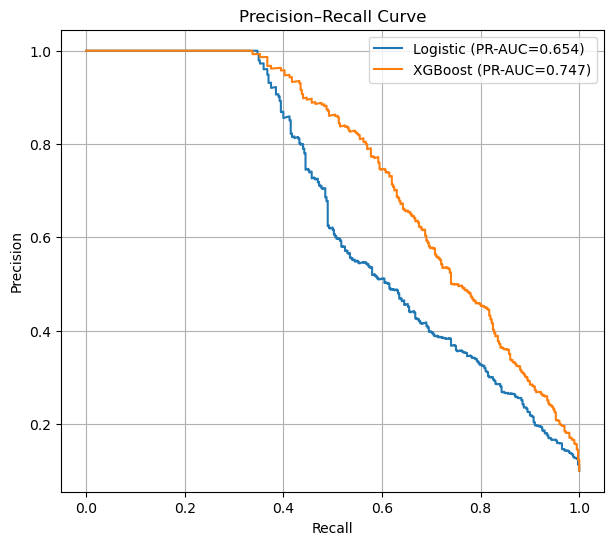

In [38]:
# Plot precision-recall curves (logistic vs tuned xgboost)
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Get probabilities
p_lr = pipe_lr.predict_proba(Xte_lin)[:, 1]
p_xgb = best_xgb.predict_proba(Xte_tree)[:, 1]

# Compute curves
prec_lr, rec_lr, _ = precision_recall_curve(y_test, p_lr)
prec_xgb, rec_xgb, _ = precision_recall_curve(y_test, p_xgb)

pr_auc_lr = average_precision_score(y_test, p_lr)
pr_auc_xgb = average_precision_score(y_test, p_xgb)

# Plot
plt.figure(figsize=(7,6))
plt.plot(rec_lr, prec_lr, label=f"Logistic (PR-AUC={pr_auc_lr:.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (PR-AUC={pr_auc_xgb:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


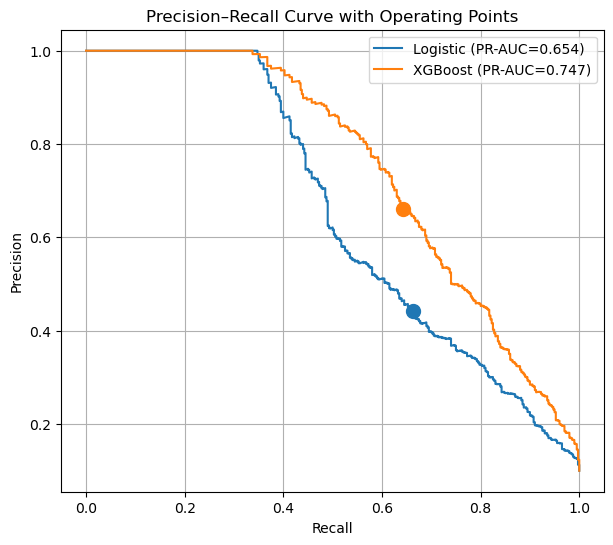

In [39]:
# Current operating points
prec_lr_current = row_lr_final["precision"]
rec_lr_current = row_lr_final["recall"]

prec_xgb_current = row_xgb_final["precision"]
rec_xgb_current = row_xgb_final["recall"]

plt.figure(figsize=(7,6))
plt.plot(rec_lr, prec_lr, label=f"Logistic (PR-AUC={pr_auc_lr:.3f})")
plt.plot(rec_xgb, prec_xgb, label=f"XGBoost (PR-AUC={pr_auc_xgb:.3f})")

plt.scatter(rec_lr_current, prec_lr_current, marker="o", s=100)
plt.scatter(rec_xgb_current, prec_xgb_current, marker="o", s=100)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve with Operating Points")
plt.legend()
plt.grid(True)
plt.show()


### 9. Threshold Optimisation & Final Scoring Output

**Objective:** Convert `churn_proba` into `churn_pred` using an economically justified threshold.

## Threshold Strategy

Select the threshold that:

> **Maximises precision subject to recall ≥ 70%**

This captures most churners while controlling outreach cost.

#### Why 70% Recall?

Churn intervention is asymmetric:

- **Missed churner (FN)** → Lost lifetime margin  
- **Wrong flag (FP)** → Retention contact cost  

Estimated economics:

- Revenue at risk per churner ≈ €224  
- Outreach cost ≈ **€20 per contact (assumption)**  
  *(Industry benchmarks for Spanish energy retail place outbound retention calls in the ~€15–30 range including agent time and incentive budget.)*

- **Breakeven precision ≈ 9%** (= 20 / 224)

At the chosen threshold:

- **Precision ≈ 61%**
- **Recall ≈ 69%**
- ~7× above breakeven

#### Operational Rationale

At ~70% recall:

- 275 / 400 churners caught  
- 452 customers contacted  
- 60.8% of flagged customers are true churners  
- higher recall inflates campaign volume, while lower recall leaves meaningful revenue at risk.

This balances revenue protection with manageable campaign volume.

The limiting factor is retention team capacity, not model economics.  
`TARGET_RECALL` can be adjusted based on budget or staffing.

In [40]:
# Step 1: Validation split from training data only (test set stays untouched)
from sklearn.model_selection import train_test_split

X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
    Xtr_tree, y_train,
    test_size=0.25,
    stratify=y_train,
    random_state=42
)

print("Train sub churn rate:", y_tr_sub.mean().round(4), "| n:", len(y_tr_sub))
print("Val   churn rate:    ", y_val.mean().round(4), "| n:", len(y_val))

Train sub churn rate: 0.0996 | n: 12059
Val   churn rate:     0.0998 | n: 4020


In [41]:
# Step 2: Fit champion model on sub-split, score validation set
import numpy as np

best_xgb.fit(X_tr_sub, y_tr_sub)
val_proba = best_xgb.predict_proba(X_val)[:, 1]

In [42]:
# Step 3: Select threshold — maximise precision at recall >= TARGET_RECALL
from sklearn.metrics import precision_recall_curve

TARGET_RECALL = 0.70  # minimum acceptable recall — adjust to reflect business tolerance

precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, val_proba)
pr = precision_curve[:-1]
re = recall_curve[:-1]

valid_idx = np.where(re >= TARGET_RECALL)[0]

if len(valid_idx) == 0:
    print(f"WARNING: No threshold achieves recall >= {TARGET_RECALL}. Falling back to best F1.")
    f1 = 2 * (pr * re) / (pr + re + 1e-12)
    best_idx = int(np.nanargmax(f1))
else:
    best_idx = valid_idx[np.argmax(pr[valid_idx])]

CHOSEN_THRESHOLD = float(thresholds[best_idx])

print(f"Target recall       : {TARGET_RECALL:.0%}")
print(f"Chosen threshold    : {CHOSEN_THRESHOLD:.4f}")
print(f"Val precision @ thr : {pr[best_idx]:.4f}")
print(f"Val recall    @ thr : {re[best_idx]:.4f}")
print(f"Val F1        @ thr : {2*pr[best_idx]*re[best_idx]/(pr[best_idx]+re[best_idx]+1e-12):.4f}")

Target recall       : 70%
Chosen threshold    : 0.6678
Val precision @ thr : 0.6176
Val recall    @ thr : 0.7007
Val F1        @ thr : 0.6565


In [43]:
# Step 4: Final evaluation on test set
# Refit on full training data before scoring test (no validation holdout)
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, accuracy_score
)

best_xgb.fit(Xtr_tree, y_train)
test_proba = best_xgb.predict_proba(Xte_tree)[:, 1]
test_pred  = (test_proba >= CHOSEN_THRESHOLD).astype(int)

print(f"{'='*48}")
print(f"Champion Model — Test Set Performance")
print(f"{'='*48}")
print(f"Threshold   : {CHOSEN_THRESHOLD:.4f}  (tuned for recall >= {TARGET_RECALL:.0%})")
print(f"ROC-AUC     : {roc_auc_score(y_test, test_proba):.4f}")
print(f"PR-AUC      : {average_precision_score(y_test, test_proba):.4f}")
print(f"Precision   : {precision_score(y_test, test_pred, zero_division=0):.4f}")
print(f"Recall      : {recall_score(y_test, test_pred, zero_division=0):.4f}")
print(f"F1          : {f1_score(y_test, test_pred, zero_division=0):.4f}")
print(f"Accuracy    : {accuracy_score(y_test, test_pred):.4f}")
print()
tn, fp, fn, tp = confusion_matrix(y_test, test_pred).ravel()
print(f"Confusion matrix:")
print(f"  True Negatives  (correctly identified non-churners) : {tn:,}")
print(f"  False Positives (non-churners flagged for outreach)  : {fp:,}")
print(f"  False Negatives (churners missed)                    : {fn:,}")
print(f"  True Positives  (churners correctly flagged)         : {tp:,}")
print()
print(f"  Of {tp+fn:,} actual churners → {tp:,} caught ({tp/(tp+fn):.1%} recall)")
print(f"  Of {tp+fp:,} flagged customers → {tp:,} are true churners ({tp/(tp+fp):.1%} precision)")

Champion Model — Test Set Performance
Threshold   : 0.6678  (tuned for recall >= 70%)
ROC-AUC     : 0.9297
PR-AUC      : 0.7468
Precision   : 0.6084
Recall      : 0.6875
F1          : 0.6455
Accuracy    : 0.9249

Confusion matrix:
  True Negatives  (correctly identified non-churners) : 3,443
  False Positives (non-churners flagged for outreach)  : 177
  False Negatives (churners missed)                    : 125
  True Positives  (churners correctly flagged)         : 275

  Of 400 actual churners → 275 caught (68.8% recall)
  Of 452 flagged customers → 275 are true churners (60.8% precision)


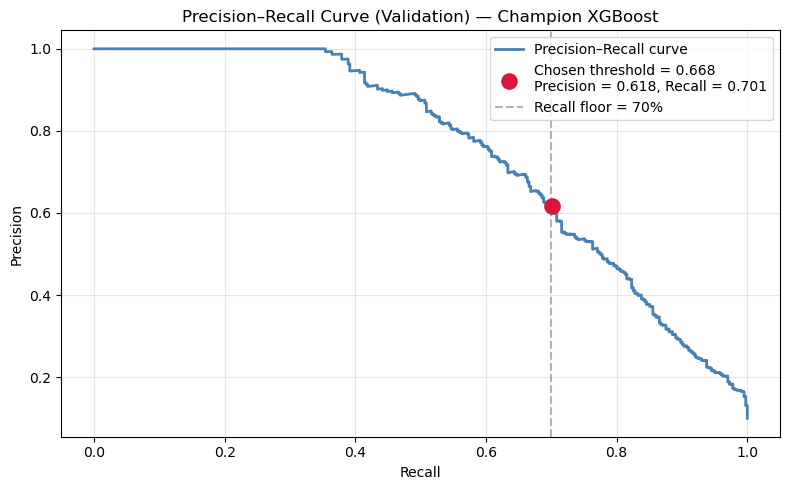

In [44]:
# Step 5: Precision–Recall curve with chosen threshold marked
import matplotlib.pyplot as plt

precision_v, recall_v, thresh_v = precision_recall_curve(y_val, val_proba)

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(recall_v, precision_v, color="steelblue", lw=2, label="Precision–Recall curve")

idx = np.argmin(np.abs(thresh_v - CHOSEN_THRESHOLD))
ax.scatter(recall_v[idx], precision_v[idx], color="crimson", s=120, zorder=5,
           label=f"Chosen threshold = {CHOSEN_THRESHOLD:.3f}\n"
                 f"Precision = {precision_v[idx]:.3f}, Recall = {recall_v[idx]:.3f}")

ax.axvline(TARGET_RECALL, color="gray", linestyle="--", alpha=0.6,
           label=f"Recall floor = {TARGET_RECALL:.0%}")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_title("Precision–Recall Curve (Validation) — Champion XGBoost")
ax.legend(loc="upper right")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 10. Final Scoring Output

**What this produces:** A scored customer table with `churn_proba`, `churn_pred`, and
`expected_monthly_loss` — the three outputs needed to run a retention campaign.

| Column | Type | Business use |
|--------|------|--------------|
| `churn_proba` | Float [0–1] | Risk ranking; input to expected value at risk |
| `churn_pred` | Binary {0,1} | Operational flag: include in outreach or not |
| `expected_monthly_loss` | Float | `churn_proba × avg_monthly_margin` — €revenue at risk per month if customer churns |

In [45]:
# Build full scoring table — all customers in gold
X_all, y_all, cid_all = build_model_matrix(gold, champion_features_tree)
all_proba = best_xgb.predict_proba(X_all)[:, 1]
all_pred  = (all_proba >= CHOSEN_THRESHOLD).astype(int)

scored = pd.DataFrame({
    "customer_id"  : cid_all.values,
    "churn_actual" : y_all.values,
    "churn_proba"  : all_proba.round(4),
    "churn_pred"   : all_pred,
})

# Attach margin + segment columns (excluded from training — business output only)
biz_cols = [c for c in ["customer_id", "avg_monthly_margin", "total_margin_2024", "segment"]
            if c in gold.columns]
scored = scored.merge(gold[biz_cols], on="customer_id", how="left")

# Expected monthly loss: P(churn) × avg monthly margin
# Interpretation: if this customer churns, we expect to lose €X per month
# Clip at 0 — negative margin customers have no revenue at risk
if "avg_monthly_margin" in scored.columns:
    scored["expected_monthly_loss"] = (
        scored["churn_proba"] * scored["avg_monthly_margin"].clip(lower=0)
    ).round(2)

scored = scored.sort_values("expected_monthly_loss", ascending=False).reset_index(drop=True)

print(f"Scored customers              : {len(scored):,}")
print(f"Flagged as churners           : {scored['churn_pred'].sum():,}  ({scored['churn_pred'].mean():.1%})")
if "expected_monthly_loss" in scored.columns:
    flagged = scored[scored["churn_pred"] == 1]
    print(f"Avg expected monthly loss (flagged) : €{flagged['expected_monthly_loss'].mean():.2f}")
    print(f"Total expected monthly loss (flagged): €{flagged['expected_monthly_loss'].sum():,.2f}")

# Segment breakdown — retention campaigns are run differently by segment
# (Corporate: account manager, Residential: SMS/email, SME: phone outreach)
if "segment" in scored.columns:
    print("\nFlagged churners by segment:")
    print(scored[scored["churn_pred"] == 1].groupby("segment").agg(
        flagged=("customer_id", "count"),
        avg_churn_proba=("churn_proba", "mean"),
        total_expected_loss=("expected_monthly_loss", "sum")
    ).round(2))

scored.head(10)

Scored customers              : 20,099
Flagged as churners           : 2,412  (12.0%)
Avg expected monthly loss (flagged) : €5.56
Total expected monthly loss (flagged): €13,400.78

Flagged churners by segment:
             flagged  avg_churn_proba  total_expected_loss
segment                                                   
Corporate         14             0.84                56.60
Residential     2170             0.84             11275.85
SME              228             0.83              2068.33


,customer_id,churn_actual,churn_proba,churn_pred,avg_monthly_margin,total_margin_2024,segment,expected_monthly_loss
0,C06100,0,0.6403,0,385.807534,4629.690410,SME,247.03
1,C16983,0,0.5300,0,356.287916,4275.454994,Residential,188.83
2,C11396,0,0.3840,0,377.013215,4524.158575,Residential,144.77
3,C03225,1,0.9982,1,111.553973,1338.647679,Residential,111.35
4,C13997,0,0.6956,1,121.635431,1459.625173,Residential,84.61
5,C01403,0,0.2255,0,345.080676,4140.968114,Residential,77.82
6,C16188,0,0.3088,0,238.275297,2859.303559,Residential,73.58
7,C12538,0,0.3939,0,173.214538,2078.574454,Residential,68.23
8,C20097,0,0.1920,0,318.529623,3822.355474,Residential,61.16
9,C02846,1,0.7676,1,79.104745,949.256945,Residential,60.72


Risk Tier Summary:


,customers,flagged_churners,avg_churn_proba,avg_margin,avg_expected_monthly_loss
risk_tier,,,,,
Low (<40%),14564,0,0.120,-7.982,0.861
Medium (40-60%),2464,0,0.496,3.154,3.488
High (60-80%),1686,1027,0.693,2.714,4.761
Critical (>80%),1385,1385,0.928,2.978,6.058


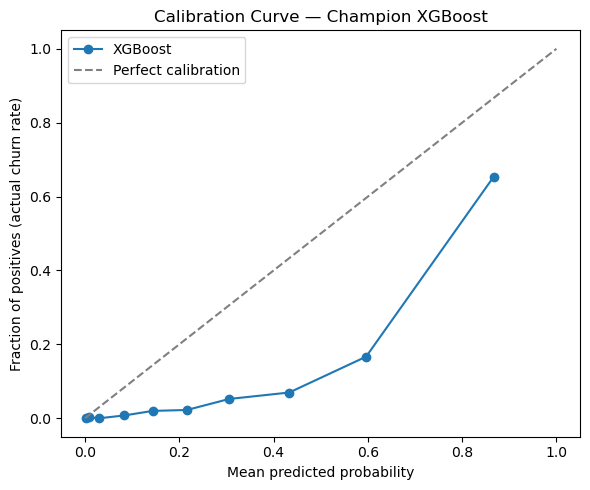

Mean calibration error: 0.1693  (< 0.05 = well-calibrated; consider Platt scaling if > 0.10)


In [46]:
# Risk tier segmentation
scored["risk_tier"] = pd.cut(
    scored["churn_proba"],
    bins=[0, 0.40, 0.60, 0.80, 1.01],
    labels=["Low (<40%)", "Medium (40-60%)", "High (60-80%)", "Critical (>80%)"],
    right=False
)

tier_summary = (
    scored.groupby("risk_tier", observed=True)
    .agg(
        customers=("customer_id", "count"),
        flagged_churners=("churn_pred", "sum"),
        avg_churn_proba=("churn_proba", "mean"),
        avg_margin=("avg_monthly_margin", "mean"),
        avg_expected_monthly_loss=("expected_monthly_loss", "mean"),
    )
    .round(3)
)

print("Risk Tier Summary:")
display(tier_summary)

# ── Calibration check ─────────────────────────────────────────────────────────
# Scores drive expected_monthly_loss calculations — verify they are well-calibrated.
# Well-calibrated: predicted P(churn)=0.6 → ~60% actual churn rate in that bucket.
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, test_proba, n_bins=10, strategy="quantile")

fig, ax = plt.subplots(figsize=(6, 5))
ax.plot(prob_pred, prob_true, marker="o", label="XGBoost")
ax.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfect calibration")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives (actual churn rate)")
ax.set_title("Calibration Curve — Champion XGBoost")
ax.legend()
plt.tight_layout()
plt.show()

mce = np.mean(np.abs(prob_true - prob_pred))
print(f"Mean calibration error: {mce:.4f}  (< 0.05 = well-calibrated; consider Platt scaling if > 0.10)")

In [47]:
# Save scored output to CSV
from pathlib import Path

# Define ARTIFACTS_DIR if not already set (fallback: same folder as notebook)
if "ARTIFACTS_DIR" not in dir():
    ARTIFACTS_DIR = Path.cwd() / "artifacts"
    print(f"ARTIFACTS_DIR not defined — defaulting to: {ARTIFACTS_DIR}")

# Create output folder if it doesn't exist
(ARTIFACTS_DIR / "scored").mkdir(parents=True, exist_ok=True)

out_path = ARTIFACTS_DIR / "scored" / "scored_customers.csv"
scored.to_csv(out_path, index=False)
print("Saved:", out_path)
print("\nOutput columns:")
for col in scored.columns:
    print(f"  {col}")

ARTIFACTS_DIR not defined — defaulting to: /Users/crissafrancisco/Desktop/IE/Third Term/Capstone/artifacts
Saved: /Users/crissafrancisco/Desktop/IE/Third Term/Capstone/artifacts/scored/scored_customers.csv

Output columns:
  customer_id
  churn_actual
  churn_proba
  churn_pred
  avg_monthly_margin
  total_margin_2024
  segment
  expected_monthly_loss
  risk_tier


## 11. Feature Importance (Champion Model)

XGBoost feature importance (gain) shows which features drive the most splits.

**This plot serves three purposes:**
1. **Model validation** — confirms the model is learning from expected signals
   (sentiment, intent, renewal proximity) rather than spurious correlations
2. **Stakeholder communication** — explains to the client *why* a customer
   was flagged, in business terms they recognise
3. **Future feature investment** — low-importance features can be deprioritised
   when the gold notebook is updated; high-importance ones should be monitored
   for data quality

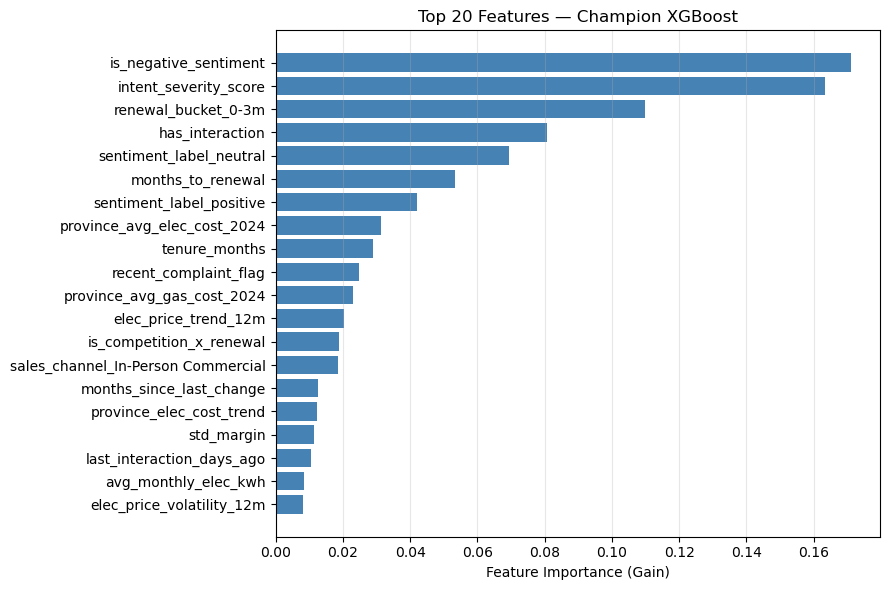

Exception ignored in: <function ResourceTracker.__del__ at 0x106aadc60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x104849c60>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x105995c60>
Traceback (most recent call last

In [48]:
# XGBoost native feature importance — top 20
import matplotlib.pyplot as plt
import numpy as np

xgb_step = best_xgb.named_steps["model"]
pre_step  = best_xgb.named_steps["preprocessor"]

try:
    raw_names = pre_step.get_feature_names_out()
    # Strip sklearn pipeline prefixes for readable labels
    feature_names = [
        n.replace("num__", "").replace("cat__", "").replace("remainder__", "")
        for n in raw_names
    ]
except AttributeError:
    feature_names = [f"f{i}" for i in range(len(xgb_step.feature_importances_))]

importances = xgb_step.feature_importances_
top_n = 20
top_idx = np.argsort(importances)[::-1][:top_n]

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(
    [feature_names[i] for i in top_idx[::-1]],
    importances[top_idx[::-1]],
    color="steelblue"
)
ax.set_xlabel("Feature Importance (Gain)")
ax.set_title(f"Top {top_n} Features — Champion XGBoost")
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()